In [6]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from pythainlp.tokenize import word_tokenize
import torch
import accelerate

In [3]:
df = pd.read_csv('../preparedata/data_train.csv')

sentences = []
labels = []
label2id = {
    "O": 0,
    "B-FOOD": 1,
    "I-FOOD": 2,
    "B-COMMAND_1": 3,
    "I-COMMAND_1": 4,
    "B-COMMAND_2": 5,
    "I-COMMAND_2": 6,
    "B-TABLE": 7,
    "I-TABLE": 8,
    "B-QUESTION": 9,
    "I-QUESTION": 10
}
id2label = {v: k for k, v in label2id.items()}

for sentence_id, group in df.groupby('SENTENCE'):
    tokens = group['WORD_TOKENIZE'].tolist()
    tags = group['TAG'].tolist()
    sentences.append(tokens)
    labels.append(tags)

encoded_labels = [[label2id[label] for label in sentence] for sentence in labels]

train_sentences, test_sentences, train_labels, test_label = train_test_split(sentences, encoded_labels, test_size=0.2)

data_traning = {
    "tokens" :train_sentences,
    "labels": train_labels
}

data_testing = {
    "tokens" :test_sentences,
    "labels": test_label
}

print("ตัวอย่าง sentence:", data_traning['labels'][0])
print("ตัวอย่าง sentence:", data_traning['tokens'][0])
print("ตัวอย่าง sentence:", data_testing['labels'][0])
print("ตัวอย่าง sentence:", data_testing['tokens'][0])

ตัวอย่าง sentence: [1, 2, 2, 7, 8, 3, 4]
ตัวอย่าง sentence: ['เฟรนฟ', 'ราย', 'ชีส', 'โต๊ะ', '3', 'เตรียม', 'แล้ว']
ตัวอย่าง sentence: [0, 0, 0, 0, 1, 2, 0, 7, 8, 0, 0, 0]
ตัวอย่าง sentence: ['โอม', 'เตรียม', 'รถไฟ', 'กับ', 'กุ้ง', 'ตะเกียบ', 'ของ', 'โต๊ะ', '7', 'ให้', 'หน่อย', 'นะ']


In [4]:
model_name = "Geotrend/bert-base-th-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    # id2label=id2label,
    # label2id=label2id
)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True, padding=True)

    label_all_tokens = True
    labels = []

    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels

    return tokenized_inputs

train_encodings = tokenize_and_align_labels(data_traning)
test_encodings = tokenize_and_align_labels(data_testing)

# สร้าง Hugging Face Dataset
train_dataset = Dataset.from_dict(train_encodings)
test_dataset = Dataset.from_dict(test_encodings)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at Geotrend/bert-base-th-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def merge_tokens_and_labels(tokens, labels):
    merged_tokens = []
    merged_labels = []

    current_word = []
    current_label = None

    for token, label in zip(tokens, labels):
        token = str(token)

        if token in ['[CLS]', '[SEP]']:
            continue

        if token.startswith("##"):
            current_word.append(token[2:])
        else:

            if current_word:
                merged_tokens.append("".join(current_word))
                merged_labels.append(current_label)

            current_word = [token]
            current_label = label

    if current_word:
        merged_tokens.append("".join(current_word))
        merged_labels.append(current_label)
    decoded_labels = [id2label[id] for id in merged_labels]

    return merged_tokens, decoded_labels

# a, b = merge_tokens_and_labels(tokenizer.convert_ids_to_tokens(train_encodings["input_ids"][0]), train_encodings["labels"][0])
# print(a)
# print(b)
print(train_encodings["input_ids"][0])

[11, 184, 7531, 3920, 2617, 7531, 169, 5754, 145, 3132, 4665, 186, 4799, 8491, 3894, 32, 184, 7938, 7716, 2939, 185, 8092, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
import torch
import accelerate
print(accelerate.__version__)
print(torch.__version__)
print(torch.cuda.is_available())
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()
results = trainer.evaluate()
print(results)

1.3.0
2.4.1+cu118
True


c:\Users\user\anaconda3\envs\env_ner\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\user\anaconda3\envs\env_ner\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss
1,No log,0.739825
2,No log,0.461168
3,No log,0.432392


{'eval_loss': 0.432392418384552, 'eval_runtime': 0.1901, 'eval_samples_per_second': 273.6, 'eval_steps_per_second': 36.831, 'epoch': 3.0}


              precision    recall  f1-score   support

           0       0.36      0.86      0.50       331
           1       0.76      0.97      0.86       239
           2       0.81      0.94      0.87       388
           3       0.51      1.00      0.67        59
           4       0.37      0.88      0.52        65
           5       0.56      0.81      0.66       135
           6       0.52      0.43      0.47       105
           7       0.71      1.00      0.83       206
           8       0.70      1.00      0.82        54
           9       0.00      0.00      0.00        31

   micro avg       0.57      0.88      0.69      1613
   macro avg       0.53      0.79      0.62      1613
weighted avg       0.61      0.88      0.71      1613



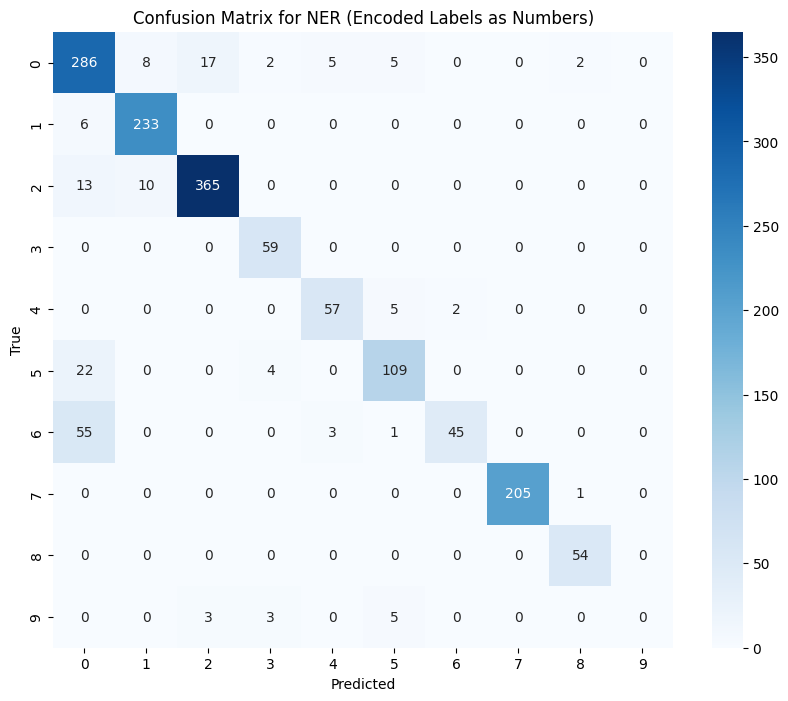

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn_crfsuite.utils import flatten

import seaborn as sns
import matplotlib.pyplot as plt

predictions = trainer.predict(test_dataset)

y_pred = np.argmax(predictions.predictions, axis=2)
y_true = test_dataset['labels']


y_pred_flat = flatten(y_pred)
y_true_flat = flatten(y_true)

sorted_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
print(classification_report(y_true_flat, y_pred_flat, labels=sorted_labels, zero_division=0))

cm = confusion_matrix(y_true_flat, y_pred_flat, labels=sorted_labels)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted_labels, yticklabels=sorted_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for NER (Encoded Labels as Numbers)')
plt.show()

              precision    recall  f1-score   support

 B-COMMAND_1       0.87      1.00      0.93        59
 I-COMMAND_1       0.88      0.88      0.88        65
 B-COMMAND_2       0.84      0.81      0.82       135
 I-COMMAND_2       0.96      0.43      0.59       105
      B-FOOD       0.93      0.97      0.95       239
      I-FOOD       0.95      0.94      0.94       388
  B-QUESTION       0.00      0.00      0.00        31
  I-QUESTION       0.50      0.82      0.62        34
     B-TABLE       1.00      1.00      1.00       206
     I-TABLE       0.95      1.00      0.97        54

   micro avg       0.91      0.88      0.90      1316
   macro avg       0.79      0.78      0.77      1316
weighted avg       0.90      0.88      0.88      1316



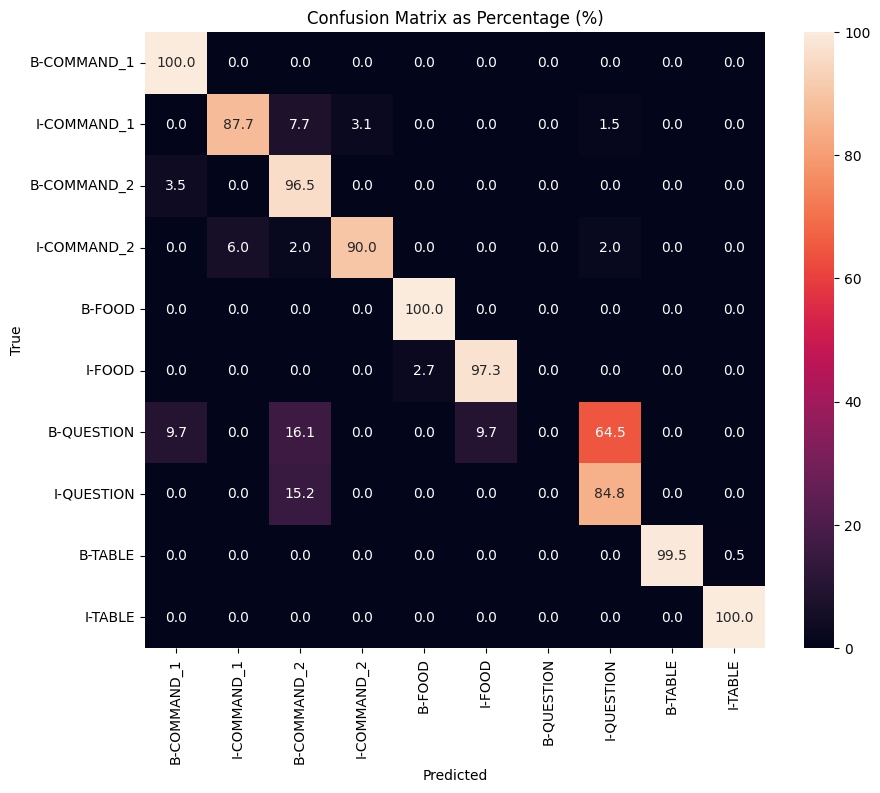

In [10]:

y_true_filtered = [true_label for true_label in y_true_flat if true_label != -100]
y_pred_filtered = [pred_label for true_label, pred_label in zip(y_true_flat, y_pred_flat) if true_label != -100]

y_pred_encoded = y_pred_text = [id2label[label] for label in y_pred_filtered]
y_true_encoded = y_pred_text = [id2label[label] for label in y_true_filtered]

sorted_labels =  ['B-COMMAND_1', 'I-COMMAND_1', 'B-COMMAND_2','I-COMMAND_2', 'B-FOOD', 'I-FOOD', 'B-QUESTION', 'I-QUESTION', 'B-TABLE', 'I-TABLE']
print(classification_report(y_true_encoded, y_pred_encoded, labels=sorted_labels, zero_division=0))
cm = confusion_matrix(y_true_encoded, y_pred_encoded, labels=sorted_labels)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.1f', xticklabels=sorted_labels, yticklabels=sorted_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix as Percentage (%)')
plt.savefig('confusion_matrix_tranformer_model.png')
plt.show()

In [1]:
model.save_pretrained('./model')
tokenizer.save_pretrained('./model')

NameError: name 'model' is not defined

In [12]:
model_path = './model'
model = AutoModelForTokenClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

text = "ขนมปังสังขยาโต๊ะ 3 แล้วก็ของโต๊ะ 4 ชั้นได้เตรียมไว้ให้เสร็จแล้วหรือยังครับผม"
word_cut = word_tokenize(text, keep_whitespace=False)

inputs = tokenizer(word_cut, truncation=True, is_split_into_words=True, padding=True, return_tensors="pt")

model.eval()

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predicted_labels = torch.argmax(logits, dim=-1)

print(len(inputs["input_ids"][0].tolist()), len(predicted_labels[0].tolist()))

predicted_labels_list = predicted_labels[0].tolist()
inputs_list = inputs["input_ids"][0].tolist()

text, tag_ner = merge_tokens_and_labels(tokenizer.convert_ids_to_tokens(inputs_list), predicted_labels_list)
print(text)
print(tag_ner)

54 54
['ขนมปัง', 'สังขยา', 'โต๊ะ', '3', 'แล้วก็', 'ของ', 'โต๊ะ', '4', 'ชั้น', 'ได้', 'เตรียม', 'ไว้', 'ให้', 'เสร็จ', 'แล้ว', 'หรือยัง', 'ครับผม']
['B-FOOD', 'I-FOOD', 'B-TABLE', 'I-TABLE', 'I-COMMAND_1', 'O', 'B-TABLE', 'I-TABLE', 'O', 'O', 'B-COMMAND_1', 'O', 'O', 'B-COMMAND_2', 'I-COMMAND_2', 'I-QUESTION', 'O']
